In [1]:
import metview as mv
import rioxarray 
import xarray
from shapely.geometry import (Polygon, mapping)
import geopandas

mv.setoutput('jupyter', output_font_scale=1.5, plot_widget=False)

#### Polígonos del parque Cerro Saroche

In [2]:
park_poligono = geopandas.read_file('./cerro_saroche/poligono_cerro_saroche/cerro_saroche.shp')
parque_rectangulo = geopandas.read_file('./cerro_saroche/poligono_cerro_saroche/rectangulo_cerro_saroche.shp')

#### Precipitación

* Transformación de la precipitación a NETCDF.

In [3]:
precipitacion_rds = rioxarray.open_rasterio('./cerro_saroche/cdsapi/total_precipitation.grib',
                              masked=True
                              )\
                              .squeeze()
# proyeccion
precipitacion_rds.rio.crs

ERROR: Ran out of file reading SECT0


CRS.from_wkt('GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6367470,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

In [4]:
import pandas as pd
from datetime import datetime

# Tranformando band a datetime 
date_range = pd.date_range(start='1970-01-01',
                          freq='M',
                          periods = precipitacion_rds.band.values.shape[0]
                          )

date_range = list(map(lambda x: datetime.strptime( str(x)[:8]+'01','%Y-%m-%d').toordinal(), date_range ))

In [5]:
# # creando netcdf
# ds_precipitacion = xarray.Dataset({
#         'precipitacion_m' : xarray.DataArray(
#                     data = precipitacion_rds.data,
#                     dims = ['band','y','x'],
#                     coords = {'band':precipitacion_rds['band'].data,'y': precipitacion_rds['y'].data, 'x': precipitacion_rds['x'].data},
#                     attrs = precipitacion_rds.attrs
#                     )
#           },
#     attrs = precipitacion_rds.attrs
#     )

# # agregando crs
# ds_precipitacion.rio.set_crs(precipitacion_rds.rio.crs)
# ds_precipitacion.rio.write_crs(precipitacion_rds.rio.crs)

# # transformacion m a mm
# ds_precipitacion['precipitacion_mm'] = 1000*ds_precipitacion.precipitacion_m
# #ds_precipitacion['date'] = date_range

# # guardando
# ds_precipitacion.to_netcdf(f"./cerro_saroche/cdsapi/total_precipitation.nc")

In [6]:
park_poligono = park_poligono.to_crs(precipitacion_rds.rio.crs)
parque_rectangulo = parque_rectangulo.to_crs(precipitacion_rds.rio.crs)

# rectangulo del parque
precipitacion_rectangulo = precipitacion_rds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                                                    all_touched=False,
                                                    crs=precipitacion_rds.rio.crs,
                                                    from_disk=True)

Text(0, 0.5, 'Latitud')

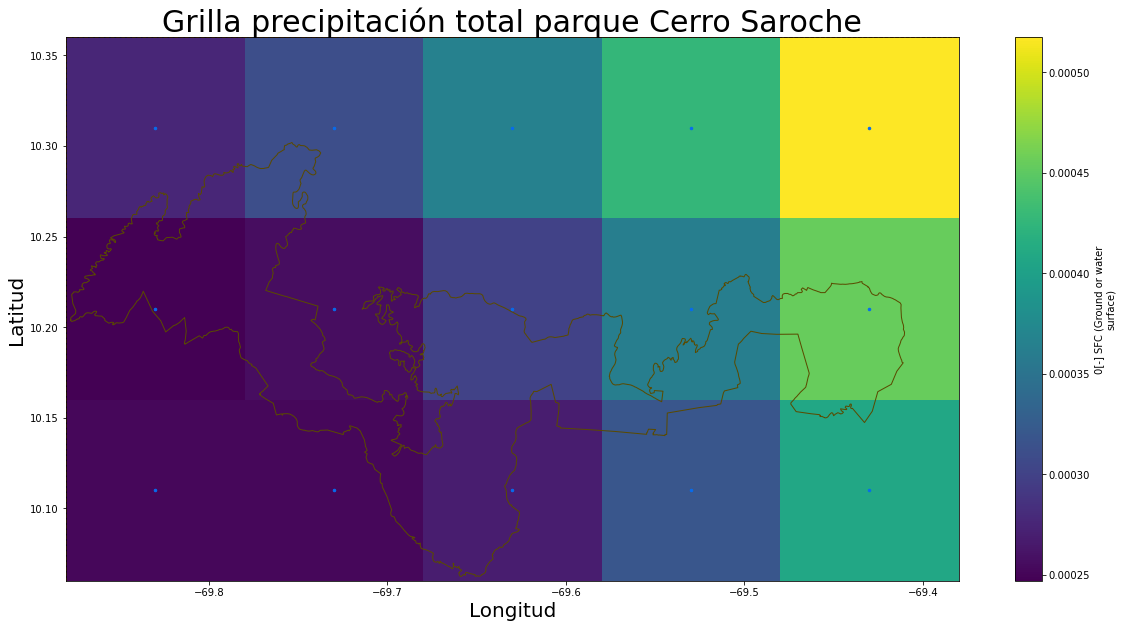

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
ax.add_collection(precipitacion_rectangulo.isel(band=625).plot())

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#5A4A00', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#076CEE', marker='.', label=i, markersize=5)

# titulos
plt.title("Grilla precipitación total parque Cerro Saroche",loc='center',fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=20)
plt.ylabel("Latitud",loc='center',fontsize=20)

#### Elevación

In [8]:
elevacion_rds = rioxarray.open_rasterio('./cerro_saroche/SRTMGL3/elevacion.nc',
                              masked=True
                              )\
                              .squeeze()\
                              .to_dataset()

elevacion = elevacion_rds.rio.reproject(precipitacion_rds.rio.crs)

In [9]:
# elevacion del parque
elevacion_park = elevacion.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

elevacion_park

<xarray.Dataset>
Dimensions:      (y: 360, x: 600)
Coordinates:
  * y            (y) float64 10.36 10.36 10.36 10.36 ... 10.06 10.06 10.06 10.06
  * x            (x) float64 -69.88 -69.88 -69.88 ... -69.38 -69.38 -69.38
    band         int64 1
    spatial_ref  int64 0
Data variables:
    elevacion    (y, x) float32 dask.array<chunksize=(360, 600), meta=np.ndarray>

Text(0, 0.5, 'Latitud')

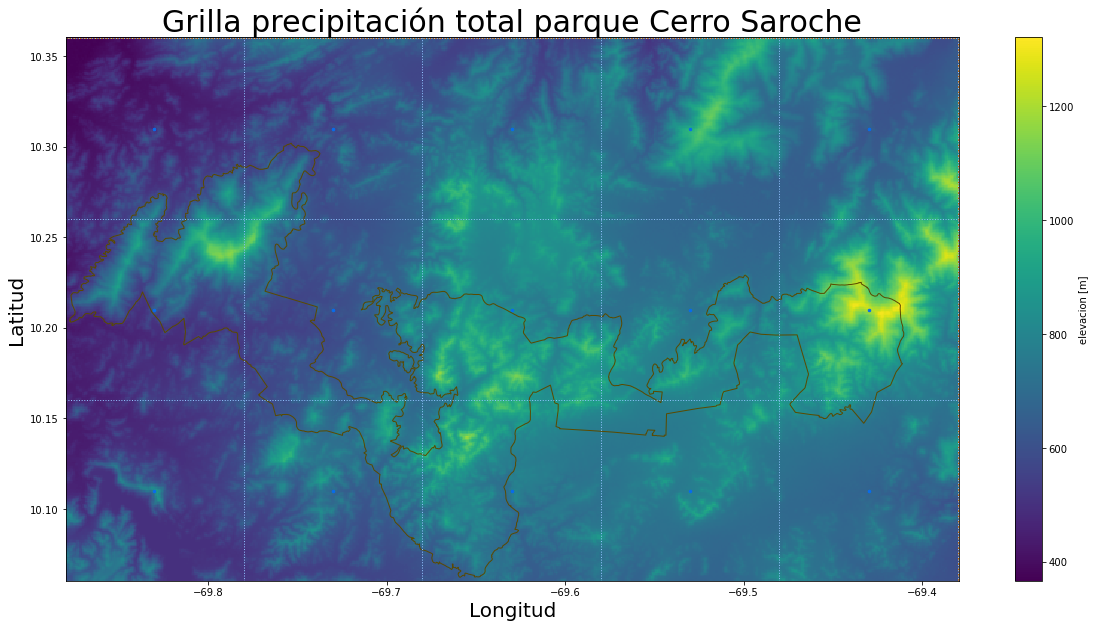

In [10]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# grilla
x_grid = x + 0.05
y_grid  = y + 0.05

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
ax.add_collection(elevacion_park.elevacion.plot())

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#5A4A00', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#076CEE', marker='.', label=i, markersize=5)

# grilla
color_grid = '#91C2FF'
for i in list(range( len(x_grid) )):
  ax.vlines(x = x_grid[i],ymin=min(y_grid),ymax=max(y_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

for i in list(range( len(y_grid) )):
  ax.hlines(y = y_grid[i],xmin=min(x_grid),xmax=max(x_grid),
            colors = color_grid,
            linestyles='dotted',
            linewidth=1,
            label = 'vline_multiple - full height')

# titulos
plt.title("Grilla precipitación total parque Cerro Saroche",loc='center',fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=20)
plt.ylabel("Latitud",loc='center',fontsize=20)

#### Regrillado elevación

In [11]:
import warnings
warnings.filterwarnings("ignore")


rds = precipitacion_rds
rds_trgrilla = elevacion
band = 'elevacion'
x_name='x'
y_name='y'

#def grilla_final(rds, rds_trgrilla, band, x_name='x', y_name='y'):

y = rds[y_name].to_numpy()
x = rds[x_name].to_numpy()

list_grid = []
for i, i_ in enumerate(y[:-1]):
  list_i = []
  for j, j_ in enumerate(x[:-1]):
    poly = Polygon( [(x[j],y[i,]),(x[j+1],y[i]),(x[j+1],y[i+1]),(x[j],y[i+1]),(x[j],y[i,])] )
    poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
    region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                          all_touched=False,
                          from_disk=True)[band]
    list_i.append({ 'x':i_,
                    'y':j_,
                    'mean': float(region.mean()),
                    'median': float(region.median()),
                    'max': float(region.max()),
                    'centroide': (float(poligono.centroid.x), float(poligono.centroid.y))
                    }) 
  
  list_grid.append(list_i)

In [12]:
centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))

In [13]:
fieldset = [{
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 1,
              "shortName": f"{band}_media",
              "values": media,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 2,
              "shortName": f"{band}_mediana",
              "values": mediana,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 3,
              "shortName": f"{band}_maxima",
              "values": maximo,
              "dataDate": 20211216,
              "dataTime": 1200
              }
              ]

ds = xarray.open_dataset(fieldset, engine="cfgrib")
ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

#ds.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

In [14]:
# elevacion del parque
ds_rect = ds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

In [15]:
ds_rect

<xarray.Dataset>
Dimensions:            (latitude: 3, longitude: 5)
Coordinates:
  * latitude           (latitude) float64 10.31 10.21 10.11
  * longitude          (longitude) float64 -69.83 -69.73 -69.63 -69.53 -69.43
    time               datetime64[ns] ...
    spatial_ref        int64 0
Data variables:
    elevacion_media    (latitude, longitude) float32 dask.array<chunksize=(3, 5), meta=np.ndarray>
    elevacion_mediana  (latitude, longitude) float32 dask.array<chunksize=(3, 5), meta=np.ndarray>
    elevacion_maxima   (latitude, longitude) float32 dask.array<chunksize=(3, 5), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    history:      2022-06-12T18:57 GRIB to CDM+CF via cfgrib-0.9.10.1/ecCodes...

Text(0, 0.5, 'Latitud')

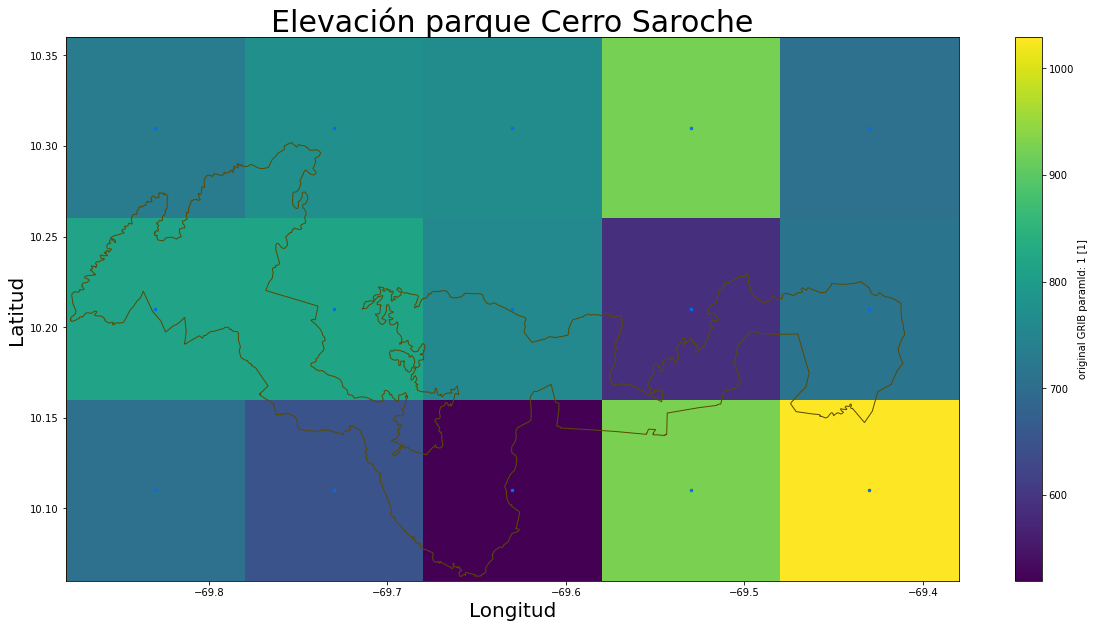

In [16]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
ax.add_collection(ds_rect.elevacion_media.plot())

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#5A4A00', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#076CEE', marker='.', label=i, markersize=5)

# titulos
plt.title("Elevación parque Cerro Saroche",loc='center',fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=20)
plt.ylabel("Latitud",loc='center',fontsize=20)

#### Vegetación

In [21]:
path_vegetacion = './cerro_saroche/MOD13Q1_V6/summary/summary.MOD13Q1V6.20120101.20220423.nc'
rds = rioxarray.open_rasterio(path_vegetacion,
                              masked=True
                              )\
                              .squeeze()
rds

<xarray.Dataset>
Dimensions:                  (y: 116, x: 221, time: 198)
Coordinates:
  * y                        (y) float64 1.145e+06 1.145e+06 ... 1.119e+06
  * x                        (x) float64 -7.647e+06 -7.647e+06 ... -7.596e+06
  * time                     (time) int64 734503 734519 734535 ... 738252 738268
    spatial_ref              int64 0
Data variables:
    250m 16 days NDVI        (time, y, x) float32 ...
    250m 16 days EVI         (time, y, x) float32 ...
    250m 16 days VI Quality  (time, y, x) float32 ...
    QA_EVI                   (time, y, x) float32 ...
    QA_NDVI                  (time, y, x) float32 ...
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

In [22]:
# cambiando proyeccion
rds_proj = rds.rio.reproject(precipitacion_rds.rio.crs)
rds_proj

<xarray.Dataset>
Dimensions:                  (x: 226, y: 105, time: 198)
Coordinates:
  * x                        (x) float64 -69.9 -69.9 -69.89 ... -69.38 -69.38
  * y                        (y) float64 10.3 10.3 10.3 ... 10.07 10.06 10.06
  * time                     (time) int64 734503 734519 734535 ... 738252 738268
    spatial_ref              int64 0
Data variables:
    250m 16 days NDVI        (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days EVI         (time, y, x) float32 nan nan nan ... nan nan nan
    250m 16 days VI Quality  (time, y, x) float32 nan nan nan ... nan nan nan
    QA_EVI                   (time, y, x) float32 nan nan nan ... nan nan nan
    QA_NDVI                  (time, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/173)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51010008
    VERSIONID:                           6
    VERTICALTILENUMBER:                  8
    WESTBOUNDINGCOORDINATE:              -81.23412894334

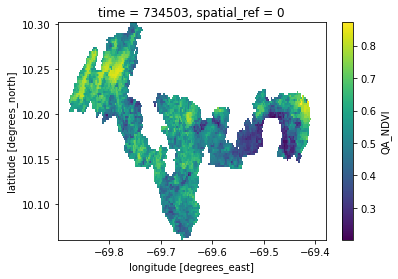

In [23]:
rds_proj.sel(time=734503).QA_NDVI.plot()

In [36]:
import warnings
warnings.filterwarnings("ignore")

from shapely.geometry import (Polygon, mapping)
import geopandas


rds = precipitacion_rds
rds_trgrilla = rds_proj.sel(time=734503)[['QA_NDVI','QA_EVI']]
band = 'QA_NDVI'
x_name='x'
y_name='y'

#def grilla_final(rds, rds_trgrilla, band, x_name='x', y_name='y'):

y = rds[y_name].to_numpy()
x = rds[x_name].to_numpy()

list_grid = []
for i, i_ in enumerate(y[:-1]):
  list_i = []
  for j, j_ in enumerate(x[:-1]):
    poly = Polygon( [(x[j],y[i,]),(x[j+1],y[i]),(x[j+1],y[i+1]),(x[j],y[i+1]),(x[j],y[i,])] )
    poligono = geopandas.GeoSeries(poly, crs = rds.rio.crs) 
    try:
      region = rds_trgrilla.rio.clip(poligono.geometry.apply(mapping),
                            all_touched=False,
                            from_disk=True)[band]
      list_i.append({ 'x':i_,
                      'y':j_,
                      'mean': float(region.mean()),
                      'median': float(region.median()),
                      'max': float(region.max()),
                      'centroide': (float(poligono.centroid.x), float(poligono.centroid.y))
                      }) 
    except:
      list_i.append({ 'x':i_,
                'y':j_,
                'mean': float(0),
                'median': float(0),
                'max': float(0),
                'centroide': (float(poligono.centroid.x), float(poligono.centroid.y))
                }) 
  
  list_grid.append(list_i)

In [33]:
centroide_x = list(map(lambda x: [y.get('centroide')[0] for y in x] , list_grid))[0]
centroide_y = list(map(lambda x: [y.get('centroide')[1] for y in x][0] , list_grid))

media = list(map(lambda x: [y.get('mean') for y in x] , list_grid))
mediana = list(map(lambda x: [y.get('median') for y in x] , list_grid))
maximo = list(map(lambda x: [y.get('max') for y in x] , list_grid))

In [38]:
fieldset = [{
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 1,
              "shortName": f"{band}_media",
              "values": media,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 2,
              "shortName": f"{band}_mediana",
              "values": mediana,
              "dataDate": 20211216,
              "dataTime": 1200
              },
              {
              "gridType": "regular_ll",
              "Nx": len(x.tolist()),
              "Ny": len(y.tolist()),
              "distinctLatitudes": y.tolist(),
              "distinctLongitudes": x.tolist(),
              "paramId": 3,
              "shortName": f"{band}_maxima",
              "values": maximo,
              "dataDate": 20211216,
              "dataTime": 1200
              }
              ]

ds = xarray.open_dataset(fieldset, engine="cfgrib")
ds = ds.rio.write_crs(precipitacion_rds.rio.crs)

#ds.to_netcdf('./cerro_saroche/SRTMGL3/elevacion_regrilla.nc')

In [40]:
# elevacion del parque
ds_rect = ds.rio.clip(parque_rectangulo.geometry.apply(mapping),
                    all_touched=False,
                    from_disk=True)\
                    .squeeze()\
                    .chunk("auto")

Text(0, 0.5, 'Latitud')

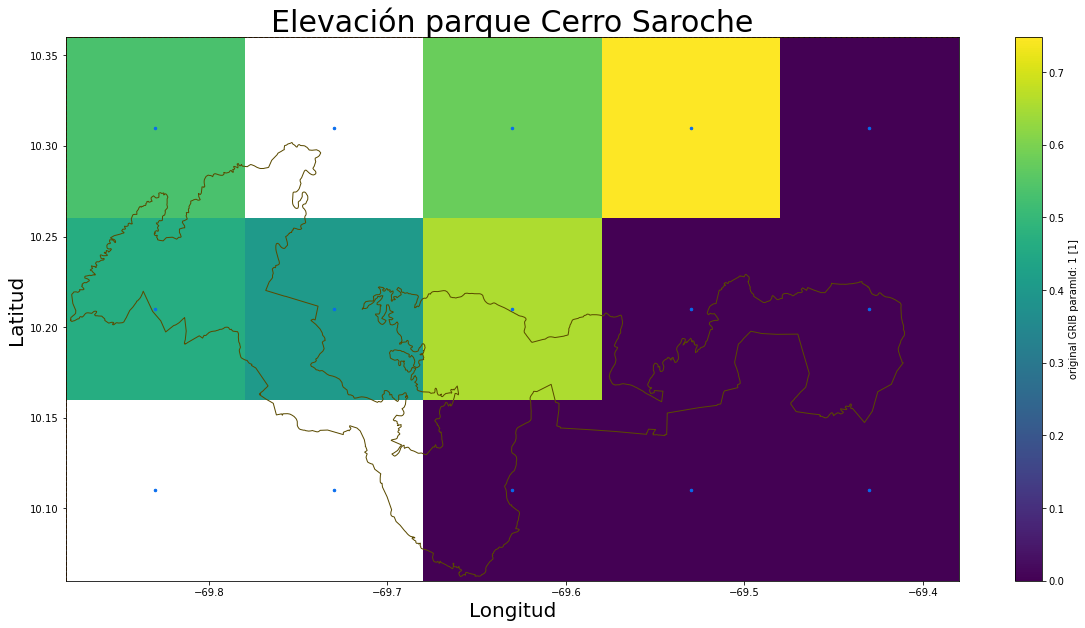

In [41]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np

# centros
x = np.arange(-70.13,-69.13,0.1)
y = np.arange(9.81,10.51,0.1)

# plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)

# raster
ax.add_collection(ds_rect.QA_NDVI_media.plot())

# poligonos
x1,y1 = park_poligono.geometry.iloc[0].exterior.xy
ax.plot(x1,y1, color='#5A4A00', linewidth=1)

x2,y2 = parque_rectangulo.geometry.iloc[0].exterior.xy
ax.plot(x2,y2, color='#BF6300', linewidth=1,linestyle='dashed')

# centroides
for i in list(range(1, len(x) )):
  for j in list(range(1, len(y) )):
    ax.plot(x[i],y[j],color = '#076CEE', marker='.', label=i, markersize=5)

# titulos
plt.title("Elevación parque Cerro Saroche",loc='center',fontsize=30)
plt.xlabel("Longitud",loc='center',fontsize=20)
plt.ylabel("Latitud",loc='center',fontsize=20)